In [2]:
%matplotlib inline
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
import matplotlib.pyplot as plt

### 读取数据集
1. 通过内嵌函数读取数据集
2. 观察数据集 有10个类别组成的图像，每个类别有6000张和1000张图组成训练集和测试集，测试集用来评估性能
3. 将数据处理成能够输入模型的数据，每个图像28*28，由灰度图组成，channel为1
4. 将文本标签转化成数字标签

In [5]:
# 通过ToTensor实例将图像数据从PIL类型变换成32位浮点数格式，
# 并除以255使得所有像素的数值均在0〜1之间
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(
root="../data", train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.FashionMNIST(
root="../data", train=False, transform=trans, download=True)

In [6]:
print(len(mnist_train))
print(len(mnist_test))

60000
10000


In [14]:
mnist_train[0][0].shape

torch.Size([1, 28, 28])

In [15]:
def get_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat','sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

In [16]:
print(get_labels)

<function get_labels at 0x000001BDCAD8F378>


### 读取小批量

In [143]:
batch_size=100
def get_dataloader_workers():
    '''使用4个进程读取数据'''
    return 4
train_iter = data.DataLoader(mnist_train,batch_size,shuffle=True,num_workers=4)
    

In [13]:
# for X,y in train_iter:
#     print(X,y)
#     break

In [11]:
# X.shape

### 图像分类的实现
1. 定义load_data函数，加载数据集。返回训练集和验证集的数据迭代，resize参数，调节图像参数
2. 对模型进行初始化，对W和b进行初始化复制，调用torch.normal()和torch.zeros()
3. 设置模型框架
4. 制定loss函数
5. 设置优化函数adam, SGD
6. 评估函数

In [144]:
def load_data(batch_size,resize=None):
    '''下载数据集，将其加载到内存中'''
    trans = [transforms.ToTensor()]
    if resize:                       #是否对原始数据进行大小变换处理
        trans.insert(0,transforms.Resize(resize))
    trans = transforms.Compose(trans)
    
    mnist_train = torchvision.datasets.FashionMNIST(
    root="../data", train=True, transform=trans, download=True)    #读取和加在数据集，使用torchvision中内置的数据
    mnist_test = torchvision.datasets.FashionMNIST(
    root="../data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train,batch_size,shuffle=True,num_workers=4),data.DataLoader(mnist_test,batch_size,shuffle=True,num_workers=4))

In [145]:
train_iter, test_iter = load_data(10,resize=None)
for X,y in train_iter:
    print(X.shape)
    break

torch.Size([10, 1, 28, 28])


In [146]:
print(get_labels(y))

['sandal', 'trouser', 'trouser', 'trouser', 'dress', 'dress', 'sneaker', 'ankle boot', 'sneaker', 'trouser']


In [147]:
#可视化训练样本
def show_image(imgs,num_rows,num_cols, titles=None, scale=1.5):
    #绘制列表
    figsize=(num_cols*scale,num_rows*scale)
    fig,axes = plt.subplots(num_rows,num_cols,figsize=figsize)   #subplot用来创建总画布
    axes=axes.flatten()
    for i,(ax,img) in enumerate(zip(axes,imgs)):
        if torch.is_tensor(img):
            ax.imshow(img.numpy())
        else:
            ax.imshow(img)
#     ax.axes.get_xaxis().set_visible(False)
#     ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

array([<AxesSubplot:title={'center':'sandal'}>,
       <AxesSubplot:title={'center':'trouser'}>,
       <AxesSubplot:title={'center':'trouser'}>,
       <AxesSubplot:title={'center':'trouser'}>,
       <AxesSubplot:title={'center':'dress'}>,
       <AxesSubplot:title={'center':'dress'}>,
       <AxesSubplot:title={'center':'sneaker'}>,
       <AxesSubplot:title={'center':'ankle boot'}>,
       <AxesSubplot:title={'center':'sneaker'}>,
       <AxesSubplot:title={'center':'trouser'}>], dtype=object)

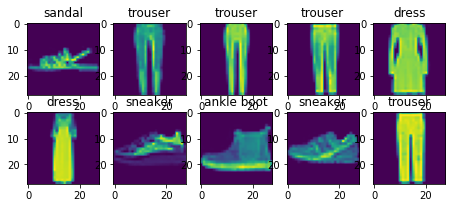

In [149]:
show_image(X.reshape(-1,28,28),2,5,titles=get_labels(y))

In [53]:
# # 可视化样本
# plt.imshow(X[0].reshape(28,28).numpy())

### 模型的初始化
在本例子中，我们将特征展开28*28展开成728，并有10个分类，因此其网络权重为[784,10]的矩阵，偏置为[1,10]的行向量，正态分布初始化权重，偏置为0

In [150]:
num_input=784
num_output=10

W=torch.normal(0,0.01,size=(num_input,num_output),requires_grad=True)
b=torch.zeros(num_output,requires_grad=True)

### softmax操作简单实现
不考虑溢出的问题

In [151]:
def softmax(X):
    X_exp = torch.exp(X)
    par = X_exp.sum(axis=1,keepdim=True)
    return X_exp/par

In [152]:
X.shape

torch.Size([10, 1, 28, 28])

In [153]:
X.reshape((-1,W.shape[0]))

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

### 定义模型

In [154]:
def net(x):
    return softmax(torch.matmul(X.reshape(-1,W.shape[0]),W)+b)

### 定义损失函数
使用交叉熵来计算损失函数，创建一个y_hat的预测值

In [156]:
y_hat = net(X)

In [157]:
y_hat[range(len(y_hat)),y]

tensor([0.0974, 0.1024, 0.0987, 0.0911, 0.0838, 0.0820, 0.0975, 0.0837, 0.1114,
        0.0956], grad_fn=<IndexBackward>)

In [158]:
y

tensor([5, 1, 1, 1, 3, 3, 7, 9, 7, 1])

In [159]:
#计算的是logP(y|x)
def cross_entropy(y_hat,y):
    return -torch.log(y_hat[range(len(y_hat)),y])
     
cross_entropy(y_hat,y)

tensor([2.3289, 2.2793, 2.3155, 2.3954, 2.4790, 2.5012, 2.3279, 2.4802, 2.1950,
        2.3473], grad_fn=<NegBackward>)

### 精度计算
使用accuracy进行精确度的计算

In [71]:
# y_hat.shape
# y_index = y_hat.argmax(axis=1)
# (y_index==y).sum()/len(y)

tensor(0)

In [164]:
def accuracy(y_hat,y):
    '''计算预测的数量'''
    if len(y_hat.shape)>1 and y_hat.shape[1]>1:
        y_hat = y_hat.argmax(axis=1)
    cmp= (y_hat.type(y.dtype)==y)
    return float(cmp.sum())
#     return float((y_hat==y).sum())/len(y)

In [165]:
a = accuracy(y_hat,y)
a

0.0

In [166]:
y.numel()

10

In [175]:
def evaluate_accuracy(net,data_iter):
    if isinstance(net,torch.nn.Module):
        net.eval()   #将net设置为评估模型。不改变参数的值
    metric = Accumulator(2)
#     metric=[0.0]*2
    with torch.no_grad():
        for X,y in data_iter:
#             acc = accuracy(net(X),y)
            metric.add(accuracy(net(X),y),y.numel())
#             metric[0]+=acc
#             metric[1]+=len(y)
#             print('acc',acc)
#             print('y',y.numel())

    return metric[0]/metric[1]

In [176]:
#用于设置存储正确的数量和预测总数的量
class Accumulator: #@save
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n
    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]
    def reset(self):
        self.data = [0.0] * len(self.data)
    def __getitem__(self, idx):
        return self.data[idx]

In [177]:
#The size of tensor a (32) must match the size of tensor b (16) at non-singleton dimension 0  
#这个错误上卡了很久，主要这个程序设计batch_size要可以被整出，将batch size改称可以被 数据量整除即可

evaluate_accuracy(net,test_iter)

0.0999

### 训练
softmax回归训练过程代码，定义一个函数训练一个迭代周期，updater是更新模型参数，接受批量大小作为参数

In [206]:
# def train(net,train_iter,loss,optimizer):
#     if isinstance(net,torch.nn.Module):
#         net.train()
#     metric = Accumulator(3)
     
#     for X,y in train_iter:
#         y_hat=net(X)
#         l = loss(y_hat,y).sum()
        
# #         if isinstance(optimizer,torch.optim.Optimizer):
#         optimizer.zero_grad()
#         l.backward()
#         optimizer.step()
# #         else:
# #             l.sum().backward()
# #             optimizer(X.shape[0])
        
#         metric.add(float(l.sum()),accuracy(y_hat,y),y.numel())
 
#     return metric[0]/metric[2],metric[1]/metric[2]
     

In [207]:
# # 循环训练多次
# def train_epoch(net,train_iter,test_iter,loss,optimizer,num_epoches):
#     for epoch in range(num_epoches):
#         train_loss,train_acc = train(net,train_iter,loss,optimizer)
#         test_acc = evaluate_accuracy(net,test_iter)
# #     train_loss,train_acc = train_metrics
#         print('train_loss',train_loss)
#         print('train_acc',train_acc)
#         print('------------------')
#     assert train_loss < 0.5, train_loss
#     assert train_acc <= 1 and train_acc > 0.7, train_acc
#     assert test_acc <= 1 and test_acc > 0.7, test_acc

In [1]:
num_epochs = 5
lr=0.1
def train_ch3(net,train_iter,test_iter,loss,optimizer,num_epoches,batch_size):
    for epoch in range(num_epochs):
        train_l_sum,train_acc_sum,n=0.0,0.0,0
        for X,y in train_iter:
            y_hat=net(X)
            l=loss(y_hat,y).sum()
            
            if optimizer is not None:
                optimizer.zero_grad()
            elif params is not None and paras[0].grad is not None:
                for param.grad.data.zero_()
                
            l = backward()
            
            if optimizer is None:
                torch.optim.SGD([W,b],lr=0.1)
            else:
                optimizer.step()
                
            train_l_sum+= l.item()
            train_acc_sum+= (y_hat.argmax(axis=1) == y).sum().item()
            n += y.shape[0]
        test_acc =  evaluate_accuracy(net,test_iter):
                
            


### 优化器

In [2]:
# lr=0.01
def optimizer(net):
    return torch.optim.SGD([W,b],lr=0.1)

In [212]:
optimizer= optimizer(net)

In [213]:
num_epochs = 10
train_epoch(net, train_iter, test_iter, cross_entropy, optimizer, num_epochs)

train_loss 2.7929236671129862
train_acc 0.1005
------------------
train_loss 2.7966126715660096
train_acc 0.10038333333333334
------------------
train_loss 2.792675044441223
train_acc 0.10221666666666666
------------------
train_loss 2.7998391566435497
train_acc 0.10053333333333334
------------------
train_loss 2.8014619698524474
train_acc 0.10071666666666666
------------------
train_loss 2.7969925147374473
train_acc 0.09976666666666667
------------------
train_loss 2.807943312740326
train_acc 0.0981
------------------
train_loss 2.798351606718699
train_acc 0.0998
------------------
train_loss 2.7957651003996533
train_acc 0.09955
------------------
train_loss 2.8004702985127765
train_acc 0.09953333333333333
------------------


AssertionError: 2.8004702985127765

### 预测

In [205]:
def predict(net,test_iter,n=6):
    for X,y in test_iter:
        break
    pre = get_labels(net(X).argmax(axis=1))
    trues = get_labels(y)
    titles = [true+'\n'+ pre for true, pre in zip(trues,pre)]
    show_image(X[0:n].shape(n,28,28),1,n,titles=titles[0:n])

In [ ]:
predict(net,test_iter)

### 初始化模型参数

In [181]:
net=nn.Sequential(nn.Flatten(),nn.Linear(784,10))

def init_weights(m):
    if type(m)==nn.Linear:
        nn.init.normal_(m.weight,std=0.01)
        
net.apply(init_weights)

NameError: name 'nn' is not defined

### 3.5小结练习
我们现在已经准备好使用Fashion-MNIST数据集，便于下面的章节调用来评估各种分类算法。

#### 小结

* Fashion-MNIST是一个服装分类数据集，由10个类别的图像组成。我们将在后续章节中使用此数据集来评估各种分类算法。
* 我们将高度$h$像素，宽度$w$像素图像的形状记为$h \times w$或（$h$,$w$）。
* 数据迭代器是获得更高性能的关键组件。依靠实现良好的数据迭代器，利用高性能计算来避免减慢训练过程。

#### 练习

1. 减少`batch_size`（如减少到1）是否会影响读取性能？
1. 数据迭代器的性能非常重要。当前的实现足够快吗？探索各种选择来改进它。
1. 查阅框架的在线API文档。还有哪些其他数据集可用？